In [1]:
import pandas as pd
import ast
import numpy as np
from pathlib import Path  
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import geopandas as gpd
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.patches import Patch
from sklearn.decomposition import PCA, FactorAnalysis
import matplotlib.colors as mcolors

import os
# os.environ["OMP_NUM_THREADS"] = "2"

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_percentage_error, mean_squared_error

#import plotly.express as px
import urllib.request
import zipfile
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import PCA, FactorAnalysis
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer


import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


# Load the Excel file
df = pd.read_csv('../../data/raw/msa-municipality.csv')
emissions = pd.read_csv('../../data/raw/2020neiMar_county_tribe_allsector/esg_cty_sector_23951.csv')

# Create a new dataframe
data = []

# Iterate through each row in the original dataframe
for index, row in df.iterrows():
    msa = row.iloc[0]  # Get the MSA
    counties = ast.literal_eval(row.iloc[1])  # Convert the string representation of the list back to a list
    
    # Append each county with its corresponding MSA to the new data list
    for county in counties:
        data.append([county, msa])

# Create a new dataframe from the data list
msa_county = pd.DataFrame(data, columns=['County', 'MSA'])

# Separate county and state
msa_county [['County Name', 'State']] = msa_county ['County'].str.split(', ', expand=True)
msa_county  = msa_county[['County Name', 'State', 'MSA']]

# Remove the word "County" from the "County Name" column
msa_county['County Name'] = msa_county['County Name'].str.replace('County', '').str.strip()


msa_county

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


County Name State                                MSA
0       Callahan    TX                        Abilene, TX
1          Jones    TX                        Abilene, TX
2         Taylor    TX                        Abilene, TX
3        Portage    OH                          Akron, OH
4         Summit    OH                          Akron, OH
...          ...   ...                                ...
1176    Trumbull    OH  Youngstown-Warren-Boardman, OH-PA
1177      Mercer    PA  Youngstown-Warren-Boardman, OH-PA
1178      Sutter    CA                      Yuba City, CA
1179        Yuba    CA                      Yuba City, CA
1180        Yuma    AZ                           Yuma, AZ

[1181 rows x 3 columns]

In [2]:
emissions

epa region code state  fips state code tribal name  fips code  \
0                      4    AL              1.0         NaN       1003   
1                      3    VA             51.0         NaN      51185   
2                      4    NC             37.0         NaN      37011   
3                      2    PR             72.0         NaN      72051   
4                      5    OH             39.0         NaN      39085   
...                  ...   ...              ...         ...        ...   
5049204                4    GA             13.0         NaN      13017   
5049205                6    LA             22.0         NaN      22033   
5049206                8    ND             38.0         NaN      38099   
5049207                4    AL              1.0         NaN       1113   
5049208                5    IN             18.0         NaN      18133   

                   county                                       sector  \
0                 Baldwin  Mobile - On-Road Diesel Heavy Duty Vehicles   
1                Tazewell        Fuel Comb - Residential - Natural Gas   
2                   Avery        Fuel Comb - Residential - Natural Gas   
3                  Dorado        Fuel Comb - Residential - Natural Gas   
4                    Lake   Fuel Comb - Industrial Boilers, ICEs - Oil   
...                   ...                                          ...   
5049204          Ben Hill                         Mobile - Locomotives   
5049205  East Baton Rouge                               Waste Disposal   
5049206             Walsh   Fuel Comb - Industrial Boilers, ICEs - Oil   
5049207           Russell                   Industrial Processes - NEC   
5049208            Putnam          Mobile - Non-Road Equipment - Other   

        reporting period emissions operating type pollutant code  \
0                      A                        R        7439976   
1                      A                        R       PM25-FIL   
2                      A                        R         PM-CON   
3                      A                        R            NOX   
4                      A                        R          83329   
...                  ...                      ...            ...   
5049204                A                        R          56553   
5049205                A                        R          78591   
5049206                A                        R         PM-CON   
5049207                A                        R            CH4   
5049208                A                        R       PM10-PRI   

                     pollutant desc pollutant type(s)  total emissions  \
0                           Mercury               HAP         0.007615   
1                  PM2.5 Filterable               CAP         0.004115   
2                    PM Condensible               CAP         0.003035   
3                   Nitrogen Oxides               CAP         0.681706   
4                      Acenaphthene               HAP         0.000774   
...                             ...               ...              ...   
5049204           Benz[a]Anthracene               HAP         0.057732   
5049205                  Isophorone               HAP        47.023000   
5049206              PM Condensible               CAP         0.181060   
5049207                     Methane               GHG         2.689640   
5049208  PM10 Primary (Filt + Cond)               CAP         0.399133   

        emissions uom data set  
0                  LB  2020NEI  
1                 TON  2020NEI  
2                 TON  2020NEI  
3                 TON  2020NEI  
4                  LB  2020NEI  
...               ...      ...  
5049204            LB  2020NEI  
5049205            LB  2020NEI  
5049206           TON  2020NEI  
5049207           TON  2020NEI  
5049208           TON  2020NEI  

[5049209 rows x 15 columns]

In [3]:
# Ensure the 'county' column in df1 and the 'County Name' column in df2 are in the same format
# Remove the word "County" if present in 'county' column
emissions['county'] = emissions['county'].str.replace('County', '').str.strip()

# Merge the dataframes
merged_df = pd.merge(emissions, msa_county, how='left', left_on=['county', 'state'], right_on=['County Name', 'State'])

# Drop the 'County Name' column as it's redundant after the merge
merged_df = merged_df.drop(columns=['County Name'])

merged_df

epa region code state  fips state code tribal name  fips code  \
0                      4    AL              1.0         NaN       1003   
1                      3    VA             51.0         NaN      51185   
2                      4    NC             37.0         NaN      37011   
3                      2    PR             72.0         NaN      72051   
4                      5    OH             39.0         NaN      39085   
...                  ...   ...              ...         ...        ...   
5057395                4    GA             13.0         NaN      13017   
5057396                6    LA             22.0         NaN      22033   
5057397                8    ND             38.0         NaN      38099   
5057398                4    AL              1.0         NaN       1113   
5057399                5    IN             18.0         NaN      18133   

                   county                                       sector  \
0                 Baldwin  Mobile - On-Road Diesel Heavy Duty Vehicles   
1                Tazewell        Fuel Comb - Residential - Natural Gas   
2                   Avery        Fuel Comb - Residential - Natural Gas   
3                  Dorado        Fuel Comb - Residential - Natural Gas   
4                    Lake   Fuel Comb - Industrial Boilers, ICEs - Oil   
...                   ...                                          ...   
5057395          Ben Hill                         Mobile - Locomotives   
5057396  East Baton Rouge                               Waste Disposal   
5057397             Walsh   Fuel Comb - Industrial Boilers, ICEs - Oil   
5057398           Russell                   Industrial Processes - NEC   
5057399            Putnam          Mobile - Non-Road Equipment - Other   

        reporting period emissions operating type pollutant code  \
0                      A                        R        7439976   
1                      A                        R       PM25-FIL   
2                      A                        R         PM-CON   
3                      A                        R            NOX   
4                      A                        R          83329   
...                  ...                      ...            ...   
5057395                A                        R          56553   
5057396                A                        R          78591   
5057397                A                        R         PM-CON   
5057398                A                        R            CH4   
5057399                A                        R       PM10-PRI   

                     pollutant desc pollutant type(s)  total emissions  \
0                           Mercury               HAP         0.007615   
1                  PM2.5 Filterable               CAP         0.004115   
2                    PM Condensible               CAP         0.003035   
3                   Nitrogen Oxides               CAP         0.681706   
4                      Acenaphthene               HAP         0.000774   
...                             ...               ...              ...   
5057395           Benz[a]Anthracene               HAP         0.057732   
5057396                  Isophorone               HAP        47.023000   
5057397              PM Condensible               CAP         0.181060   
5057398                     Methane               GHG         2.689640   
5057399  PM10 Primary (Filt + Cond)               CAP         0.399133   

        emissions uom data set State                               MSA  
0                  LB  2020NEI    AL         Daphne-Fairhope-Foley, AL  
1                 TON  2020NEI   NaN                               NaN  
2                 TON  2020NEI   NaN                               NaN  
3                 TON  2020NEI   NaN                               NaN  
4                  LB  2020NEI    OH              Cleveland-Elyria, OH  
...               ...      ...   ...                               ...  
5057395       

In [4]:
# Assuming your DataFrame is named df
mobile_emissions = merged_df[merged_df['sector'].isin(['Mobile - On-Road Diesel Heavy Duty Vehicles', 'Mobile - On-Road non-Diesel Light Duty Vehicles','Mobile - Locomotives','Mobile - Non-Road Equipment - Diesel','Mobile - Non-Road Equipment - Gasoline',
                                                        'Mobile - Commercial Marine Vessels','Mobile - On-Road Diesel Light Duty Vehicles','Mobile - Non-Road Equipment - Other','Mobile - On-Road non-Diesel Heavy Duty Vehicles',])]

In [5]:
mobile_emissions

epa region code state  fips state code tribal name  fips code  \
0                      4    AL              1.0         NaN       1003   
6                      7    NE             31.0         NaN      31159   
7                      4    FL             12.0         NaN      12121   
8                      6    TX             48.0         NaN      48099   
10                     8    ND             38.0         NaN      38053   
...                  ...   ...              ...         ...        ...   
5057385                4    GA             13.0         NaN      13269   
5057388                5    IN             18.0         NaN      18023   
5057390                6    OK             40.0         NaN      40147   
5057395                4    GA             13.0         NaN      13017   
5057399                5    IN             18.0         NaN      18133   

             county                                           sector  \
0           Baldwin      Mobile - On-Road Diesel Heavy Duty Vehicles   
6            Seward  Mobile - On-Road non-Diesel Light Duty Vehicles   
7          Suwannee             Mobile - Non-Road Equipment - Diesel   
8           Coryell                             Mobile - Locomotives   
10         McKenzie  Mobile - On-Road non-Diesel Light Duty Vehicles   
...             ...                                              ...   
5057385      Taylor              Mobile - Non-Road Equipment - Other   
5057388     Clinton      Mobile - On-Road Diesel Heavy Duty Vehicles   
5057390  Washington           Mobile - Non-Road Equipment - Gasoline   
5057395    Ben Hill                             Mobile - Locomotives   
5057399      Putnam              Mobile - Non-Road Equipment - Other   

        reporting period emissions operating type pollutant code  \
0                      A                        R        7439976   
6                      A                        R         107028   
7                      A                        R            CO2   
8                      A                        R         205992   
10                     A                        R         207089   
...                  ...                      ...            ...   
5057385                A                        R       PM25-PRI   
5057388                A                        R            N2O   
5057390                A                        R          83329   
5057395                A                        R          56553   
5057399                A                        R       PM10-PRI   

                      pollutant desc pollutant type(s)  total emissions  \
0                            Mercury               HAP         0.007615   
6                           Acrolein               HAP        81.528177   
7                     Carbon Dioxide               GHG     20597.826150   
8               Benzo[b]Fluoranthene               HAP         0.003568   
10              Benzo[k]Fluoranthene               HAP         0.902461   
...                              ...               ...              ...   
5057385  PM2.5 Primary (Filt + Cond)               CAP         0.016915   
5057388                Nitrous Oxide               GHG         0.215948   
5057390                 Acenaphthene               HAP         4.440124   
5057395            Benz[a]Anthracene               HAP         0.057732   
5057399   PM10 Primary (Filt + Cond)               CAP         0.399133   

        emissions uom data set State                               MSA  
0                  LB  2020NEI    AL         Daphne-Fairhope-Foley, AL  
6                  LB  2020NEI    NE                       Lincoln, NE  
7                 TON  2020NEI   NaN                               NaN  
8                  LB  2020NEI    TX                Killeen-Temple, TX  
10                 LB  2020NEI   NaN                               NaN  
...               ...      ...   ...                               ...  
5057385           TON  202

In [6]:
mobile_emissions_clean = mobile_emissions[mobile_emissions['emissions uom'].isin(['TON'])]
mobile_emissions_clean 

epa region code state  fips state code tribal name  fips code  \
7                      4    FL             12.0         NaN      12121   
14                     5    IN             18.0         NaN      18145   
17                     5    MI             26.0         NaN      26025   
28                     7    NE             31.0         NaN      31049   
32                     8    WY             56.0         NaN      56037   
...                  ...   ...              ...         ...        ...   
5057368                4    TN             47.0         NaN      47053   
5057384                5    OH             39.0         NaN      39001   
5057385                4    GA             13.0         NaN      13269   
5057388                5    IN             18.0         NaN      18023   
5057399                5    IN             18.0         NaN      18133   

             county                                           sector  \
7          Suwannee             Mobile - Non-Road Equipment - Diesel   
14           Shelby           Mobile - Non-Road Equipment - Gasoline   
17          Calhoun               Mobile - Commercial Marine Vessels   
28            Deuel      Mobile - On-Road Diesel Heavy Duty Vehicles   
32       Sweetwater      Mobile - On-Road Diesel Light Duty Vehicles   
...             ...                                              ...   
5057368      Gibson               Mobile - Commercial Marine Vessels   
5057384       Adams  Mobile - On-Road non-Diesel Light Duty Vehicles   
5057385      Taylor              Mobile - Non-Road Equipment - Other   
5057388     Clinton      Mobile - On-Road Diesel Heavy Duty Vehicles   
5057399      Putnam              Mobile - Non-Road Equipment - Other   

        reporting period emissions operating type pollutant code  \
7                      A                        R            CO2   
14                     A                        R       PM25-PRI   
17                     A                        R    DIESEL-PM10   
28                     A                        R       PM10-PRI   
32                     A                        R            VOC   
...                  ...                      ...            ...   
5057368                A                        R             OC   
5057384                A                        R             CO   
5057385                A                        R       PM25-PRI   
5057388                A                        R            N2O   
5057399                A                        R       PM10-PRI   

                                   pollutant desc pollutant type(s)  \
7                                  Carbon Dioxide               GHG   
14                    PM2.5 Primary (Filt + Cond)               CAP   
17       PM10-Primary from certain diesel engines             Other   
28                     PM10 Primary (Filt + Cond)               CAP   
32                     Volatile Organic Compounds               CAP   
...                                           ...               ...   
5057368       Organic Carbon portion of PM2.5-PRI             Other   
5057384                           Carbon Monoxide               CAP   
5057385               PM2.5 Primary (Filt + Cond)               CAP   
5057388                             Nitrous Oxide               GHG   
5057399                PM10 Primary (Filt + Cond)               CAP   

         total emissions emissions uom data set State  \
7           20597.826150           TON  2020NEI   NaN   
14              3.697588           TON  2020NEI    IN   
17              0.000020           TON  2020NEI    MI   
28             13.017991           TON  2020NEI   NaN   
32             24.625419           TON  2020NEI   NaN   
...                  ...           ...      ...   ...   
5057368         0.000073           TON  2020NEI    TN   
5057384      1442.555253           TON  2020NEI   NaN   
5057385         0.016915           TON  2020NEI   NaN   
5057388        

In [7]:
mobile_emissions_sorted = mobile_emissions_clean.sort_values(by=['epa region code', 'county'])
mobile_emissions_sorted 

epa region code state  fips state code tribal name  fips code  \
5890                   1    VT             50.0         NaN      50001   
29200                  1    VT             50.0         NaN      50001   
79034                  1    VT             50.0         NaN      50001   
89313                  1    VT             50.0         NaN      50001   
110518                 1    VT             50.0         NaN      50001   
...                  ...   ...              ...         ...        ...   
3971252              999    DM             85.0         NaN      85002   
4007291              999    DM             85.0         NaN      85002   
4012344              999    DM             85.0         NaN      85002   
4204176              999    DM             85.0         NaN      85002   
4792988              999    DM             85.0         NaN      85002   

                                    county  \
5890                               Addison   
29200                              Addison   
79034                              Addison   
89313                              Addison   
110518                             Addison   
...                                    ...   
3971252  Federal Waters - US South Pacific   
4007291  Federal Waters - US South Pacific   
4012344  Federal Waters - US South Pacific   
4204176  Federal Waters - US South Pacific   
4792988  Federal Waters - US South Pacific   

                                                  sector reporting period  \
5890     Mobile - On-Road non-Diesel Heavy Duty Vehicles                A   
29200    Mobile - On-Road non-Diesel Heavy Duty Vehicles                A   
79034    Mobile - On-Road non-Diesel Heavy Duty Vehicles                A   
89313        Mobile - On-Road Diesel Light Duty Vehicles                A   
110518                              Mobile - Locomotives                A   
...                                                  ...              ...   
3971252               Mobile - Commercial Marine Vessels                A   
4007291               Mobile - Commercial Marine Vessels                A   
4012344               Mobile - Commercial Marine Vessels                A   
4204176               Mobile - Commercial Marine Vessels                A   
4792988               Mobile - Commercial Marine Vessels                A   

        emissions operating type pollutant code  \
5890                           R            SO4   
29200                          R            NOX   
79034                          R            NH3   
89313                          R         PMFINE   
110518                         R            NOX   
...                          ...            ...   
3971252                        R            NO3   
4007291                        R       PM25-PRI   
4012344                        R            SO2   
4204176                        R    DIESEL-PM10   
4792988                        R    DIESEL-PM25   

                                   pollutant desc pollutant type(s)  \
5890                 Sulfate Portion of PM2.5-PRI             Other   
29200                             Nitrogen Oxides               CAP   
79034                                     Ammonia               CAP   
89313       Remaining PMFINE portion of PM2.5-PRI             Other   
110518                            Nitrogen Oxides               CAP   
...                                           ...               ...   
3971252              Nitrate portion of PM2.5-PRI             Other   
4007291               PM2.5 Primary (Filt + Cond)               CAP   
4012344                            Sulfur Dioxide               CAP   
4204176  PM10-Primary from certain diesel engines             Other   
4792988  PM25-Primary from certain diesel engines             Other   

         total emissions emissions uom data set State  MSA  
5890            0.001259           TON  2020NEI   NaN  NaN  
29200           3.208368           TON  2020NEI   NaN 

In [8]:
mobile_emissions_sorted .dropna(subset=['MSA'], inplace=True)
mobile_emissions_sorted 

epa region code state  fips state code tribal name  fips code  \
35124                  1    ME             23.0         NaN      23001   
35768                  1    ME             23.0         NaN      23001   
61879                  1    ME             23.0         NaN      23001   
91429                  1    ME             23.0         NaN      23001   
122358                 1    ME             23.0         NaN      23001   
...                  ...   ...              ...         ...        ...   
4905442               10    OR             41.0         NaN      41071   
4923068               10    OR             41.0         NaN      41071   
4969500               10    OR             41.0         NaN      41071   
4972795               10    OR             41.0         NaN      41071   
4987596               10    OR             41.0         NaN      41071   

               county                                           sector  \
35124    Androscoggin      Mobile - On-Road Diesel Heavy Duty Vehicles   
35768    Androscoggin  Mobile - On-Road non-Diesel Heavy Duty Vehicles   
61879    Androscoggin  Mobile - On-Road non-Diesel Light Duty Vehicles   
91429    Androscoggin             Mobile - Non-Road Equipment - Diesel   
122358   Androscoggin      Mobile - On-Road Diesel Heavy Duty Vehicles   
...               ...                                              ...   
4905442       Yamhill             Mobile - Non-Road Equipment - Diesel   
4923068       Yamhill      Mobile - On-Road Diesel Heavy Duty Vehicles   
4969500       Yamhill             Mobile - Non-Road Equipment - Diesel   
4972795       Yamhill                             Mobile - Locomotives   
4987596       Yamhill           Mobile - Non-Road Equipment - Gasoline   

        reporting period emissions operating type pollutant code  \
35124                  A                        R            CH4   
35768                  A                        R            N2O   
61879                  A                        R             CO   
91429                  A                        R       PM25-PRI   
122358                 A                        R         PMFINE   
...                  ...                      ...            ...   
4905442                A                        R            NOX   
4923068                A                        R            VOC   
4969500                A                        R            CO2   
4972795                A                        R            NOX   
4987596                A                        R       PM10-PRI   

                                pollutant desc pollutant type(s)  \
35124                                  Methane               GHG   
35768                            Nitrous Oxide               GHG   
61879                          Carbon Monoxide               CAP   
91429              PM2.5 Primary (Filt + Cond)               CAP   
122358   Remaining PMFINE portion of PM2.5-PRI             Other   
...                                        ...               ...   
4905442                        Nitrogen Oxides               CAP   
4923068             Volatile Organic Compounds               CAP   
4969500                         Carbon Dioxide               GHG   
4972795                        Nitrogen Oxides               CAP   
4987596             PM10 Primary (Filt + Cond)               CAP   

         total emissions emissions uom data set State  \
35124           2.715788           TON  2020NEI    ME   
35768           0.652969           TON  2020NEI    ME   
61879        3241.058482           TON  2020NEI    ME   
91429           7.760108           TON  2020NEI    ME   
122358          1.479679           TON  2020NEI    ME   
...                  ...           ...      ...   ...   
4905442       195.500672           TON  2020NEI    OR   
4923068        17.918402           TON  2020NEI    OR   
4969500     43393.553380           TON  2020NEI    OR   
4972795        24.808740   

In [9]:
unique_state = mobile_emissions_sorted['State'].unique()
unique_state

array(['ME', 'MA', 'RI', 'VT', 'CT', 'NH', 'NY', 'NJ', 'PA', 'VA', 'MD',
       'WV', 'DC', 'DE', 'SC', 'FL', 'NC', 'KY', 'TN', 'AL', 'GA', 'MS',
       'IL', 'IN', 'OH', 'MN', 'MI', 'WI', 'LA', 'TX', 'AR', 'NM', 'OK',
       'MO', 'IA', 'KS', 'NE', 'CO', 'UT', 'ND', 'MT', 'WY', 'SD', 'CA',
       'NV', 'AZ', 'HI', 'ID', 'WA', 'OR'], dtype=object)

In [10]:
unique_msa = mobile_emissions_sorted['MSA'].unique()
len(unique_msa)

378

Data Exploratory Analysis

In [11]:
#each histogram show the spread and skewness of each variables, the plot is a pair plot or scatter plot matrix: each histogram represents the distribution of a single variables
#If the points in a scatter plot form a pattern that slopes upwards from left to right, this indicates a positive correlation between the two variables. For example, the scatter plots between "Carbon Dioxide" and "Methane" (second row, first column) and between "Carbon Dioxide" and "Nitrous Oxide" (third row, first column) both show a positive correlation.
#If the points in a scatter plot are randomly distributed with no clear pattern, this indicates no correlation between the two variables.
#The histograms on the diagonals show the shape of the distributions of each variable. For example, the histogram for "Methane" shows a right-skewed distribution, while "Carbon Dioxide" and "Nitrous Oxide" also show similar distributions.

#Methane vs. Carbon Dioxide: Shows a positive correlation, meaning that higher values of "Carbon Dioxide" tend to be associated with higher values of "Methane".
#Methane vs. Nitrous Oxide: Shows a positive correlation as well, indicating that higher values of "Nitrous Oxide" tend to be associated with higher values of "Methane".
#Carbon Dioxide vs. Nitrous Oxide: Shows a strong positive correlation, indicating that higher values of "Nitrous Oxide" tend to be associated with higher values of "Carbon Dioxide".

In [12]:
#If PC1 explains a very high percentage of the variance (close to 100%), it might suggest that your dataset has strong underlying patterns or structures that align well with this principal component. This could mean that your data is highly structured or that there are dominant factors influencing its variability.

#divided into different sector

In [13]:
# Filter rows where 'pollutant type(s)' is 'GHG'
ghg_msa = mobile_emissions_sorted[mobile_emissions_sorted['pollutant type(s)'] == 'GHG']
ghg_msa

epa region code state  fips state code tribal name  fips code  \
35124                  1    ME             23.0         NaN      23001   
35768                  1    ME             23.0         NaN      23001   
561624                 1    ME             23.0         NaN      23001   
689178                 1    ME             23.0         NaN      23001   
936313                 1    ME             23.0         NaN      23001   
...                  ...   ...              ...         ...        ...   
4244658               10    OR             41.0         NaN      41071   
4424920               10    OR             41.0         NaN      41071   
4490364               10    OR             41.0         NaN      41071   
4872160               10    OR             41.0         NaN      41071   
4969500               10    OR             41.0         NaN      41071   

               county                                           sector  \
35124    Androscoggin      Mobile - On-Road Diesel Heavy Duty Vehicles   
35768    Androscoggin  Mobile - On-Road non-Diesel Heavy Duty Vehicles   
561624   Androscoggin      Mobile - On-Road Diesel Light Duty Vehicles   
689178   Androscoggin      Mobile - On-Road Diesel Heavy Duty Vehicles   
936313   Androscoggin      Mobile - On-Road Diesel Light Duty Vehicles   
...               ...                                              ...   
4244658       Yamhill  Mobile - On-Road non-Diesel Light Duty Vehicles   
4424920       Yamhill      Mobile - On-Road Diesel Heavy Duty Vehicles   
4490364       Yamhill                             Mobile - Locomotives   
4872160       Yamhill  Mobile - On-Road non-Diesel Heavy Duty Vehicles   
4969500       Yamhill             Mobile - Non-Road Equipment - Diesel   

        reporting period emissions operating type pollutant code  \
35124                  A                        R            CH4   
35768                  A                        R            N2O   
561624                 A                        R            CH4   
689178                 A                        R            N2O   
936313                 A                        R            N2O   
...                  ...                      ...            ...   
4244658                A                        R            N2O   
4424920                A                        R            CH4   
4490364                A                        R            CO2   
4872160                A                        R            N2O   
4969500                A                        R            CO2   

         pollutant desc pollutant type(s)  total emissions emissions uom  \
35124           Methane               GHG         2.715788           TON   
35768     Nitrous Oxide               GHG         0.652969           TON   
561624          Methane               GHG         0.631581           TON   
689178    Nitrous Oxide               GHG         0.213074           TON   
936313    Nitrous Oxide               GHG         0.040999           TON   
...                 ...               ...              ...           ...   
4244658   Nitrous Oxide               GHG        14.977418           TON   
4424920         Methane               GHG         2.034180           TON   
4490364  Carbon Dioxide               GHG      1407.756000           TON   
4872160   Nitrous Oxide               GHG         0.287788           TON   
4969500  Carbon Dioxide               GHG     43393.553380           TON   

        data set State                                  MSA  
35124    2020NEI    ME                  Lewiston-Auburn, ME  
35768    2020NEI    ME                  Lewiston-Auburn, ME  
561624   2020NEI    ME                  Lewiston-Auburn, ME  
689178   2020NEI    ME                  Lewiston-Auburn, ME  
936313   2020NEI    ME                  Lewiston-Auburn, ME  
...          ...   ...                                  ...  
4244658  2020NEI    OR  Portland-Vancouver-Hillsboro, OR-WA  
44249

In [14]:
# Define weights for pollutants
weights = {'CH4': 25, 'N2O': 298}

# Apply the weights
ghg_msa['carbon dioxide equivalent (Ton)'] = ghg_msa.apply(
    lambda row: row['total emissions'] * weights.get(row['pollutant code'], 1),
    axis=1
)

C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_9864\3246323471.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ghg_msa['carbon dioxide equivalent (Ton)'] = ghg_msa.apply(


In [15]:
ghg_msa

epa region code state  fips state code tribal name  fips code  \
35124                  1    ME             23.0         NaN      23001   
35768                  1    ME             23.0         NaN      23001   
561624                 1    ME             23.0         NaN      23001   
689178                 1    ME             23.0         NaN      23001   
936313                 1    ME             23.0         NaN      23001   
...                  ...   ...              ...         ...        ...   
4244658               10    OR             41.0         NaN      41071   
4424920               10    OR             41.0         NaN      41071   
4490364               10    OR             41.0         NaN      41071   
4872160               10    OR             41.0         NaN      41071   
4969500               10    OR             41.0         NaN      41071   

               county                                           sector  \
35124    Androscoggin      Mobile - On-Road Diesel Heavy Duty Vehicles   
35768    Androscoggin  Mobile - On-Road non-Diesel Heavy Duty Vehicles   
561624   Androscoggin      Mobile - On-Road Diesel Light Duty Vehicles   
689178   Androscoggin      Mobile - On-Road Diesel Heavy Duty Vehicles   
936313   Androscoggin      Mobile - On-Road Diesel Light Duty Vehicles   
...               ...                                              ...   
4244658       Yamhill  Mobile - On-Road non-Diesel Light Duty Vehicles   
4424920       Yamhill      Mobile - On-Road Diesel Heavy Duty Vehicles   
4490364       Yamhill                             Mobile - Locomotives   
4872160       Yamhill  Mobile - On-Road non-Diesel Heavy Duty Vehicles   
4969500       Yamhill             Mobile - Non-Road Equipment - Diesel   

        reporting period emissions operating type pollutant code  \
35124                  A                        R            CH4   
35768                  A                        R            N2O   
561624                 A                        R            CH4   
689178                 A                        R            N2O   
936313                 A                        R            N2O   
...                  ...                      ...            ...   
4244658                A                        R            N2O   
4424920                A                        R            CH4   
4490364                A                        R            CO2   
4872160                A                        R            N2O   
4969500                A                        R            CO2   

         pollutant desc pollutant type(s)  total emissions emissions uom  \
35124           Methane               GHG         2.715788           TON   
35768     Nitrous Oxide               GHG         0.652969           TON   
561624          Methane               GHG         0.631581           TON   
689178    Nitrous Oxide               GHG         0.213074           TON   
936313    Nitrous Oxide               GHG         0.040999           TON   
...                 ...               ...              ...           ...   
4244658   Nitrous Oxide               GHG        14.977418           TON   
4424920         Methane               GHG         2.034180           TON   
4490364  Carbon Dioxide               GHG      1407.756000           TON   
4872160   Nitrous Oxide               GHG         0.287788           TON   
4969500  Carbon Dioxide               GHG     43393.553380           TON   

        data set State                                  MSA  \
35124    2020NEI    ME                  Lewiston-Auburn, ME   
35768    2020NEI    ME                  Lewiston-Auburn, ME   
561624   2020NEI    ME                  Lewiston-Auburn, ME   
689178   2020NEI    ME                  Lewiston-Auburn, ME   
936313   2020NEI    ME                  Lewiston-Auburn, ME   
...          ...   ...                                  ...   
4244658  2020NEI    OR  Portland-Vancouver-Hillsboro, OR-WA 

In [16]:
ghg_msa

epa region code state  fips state code tribal name  fips code  \
35124                  1    ME             23.0         NaN      23001   
35768                  1    ME             23.0         NaN      23001   
561624                 1    ME             23.0         NaN      23001   
689178                 1    ME             23.0         NaN      23001   
936313                 1    ME             23.0         NaN      23001   
...                  ...   ...              ...         ...        ...   
4244658               10    OR             41.0         NaN      41071   
4424920               10    OR             41.0         NaN      41071   
4490364               10    OR             41.0         NaN      41071   
4872160               10    OR             41.0         NaN      41071   
4969500               10    OR             41.0         NaN      41071   

               county                                           sector  \
35124    Androscoggin      Mobile - On-Road Diesel Heavy Duty Vehicles   
35768    Androscoggin  Mobile - On-Road non-Diesel Heavy Duty Vehicles   
561624   Androscoggin      Mobile - On-Road Diesel Light Duty Vehicles   
689178   Androscoggin      Mobile - On-Road Diesel Heavy Duty Vehicles   
936313   Androscoggin      Mobile - On-Road Diesel Light Duty Vehicles   
...               ...                                              ...   
4244658       Yamhill  Mobile - On-Road non-Diesel Light Duty Vehicles   
4424920       Yamhill      Mobile - On-Road Diesel Heavy Duty Vehicles   
4490364       Yamhill                             Mobile - Locomotives   
4872160       Yamhill  Mobile - On-Road non-Diesel Heavy Duty Vehicles   
4969500       Yamhill             Mobile - Non-Road Equipment - Diesel   

        reporting period emissions operating type pollutant code  \
35124                  A                        R            CH4   
35768                  A                        R            N2O   
561624                 A                        R            CH4   
689178                 A                        R            N2O   
936313                 A                        R            N2O   
...                  ...                      ...            ...   
4244658                A                        R            N2O   
4424920                A                        R            CH4   
4490364                A                        R            CO2   
4872160                A                        R            N2O   
4969500                A                        R            CO2   

         pollutant desc pollutant type(s)  total emissions emissions uom  \
35124           Methane               GHG         2.715788           TON   
35768     Nitrous Oxide               GHG         0.652969           TON   
561624          Methane               GHG         0.631581           TON   
689178    Nitrous Oxide               GHG         0.213074           TON   
936313    Nitrous Oxide               GHG         0.040999           TON   
...                 ...               ...              ...           ...   
4244658   Nitrous Oxide               GHG        14.977418           TON   
4424920         Methane               GHG         2.034180           TON   
4490364  Carbon Dioxide               GHG      1407.756000           TON   
4872160   Nitrous Oxide               GHG         0.287788           TON   
4969500  Carbon Dioxide               GHG     43393.553380           TON   

        data set State                                  MSA  \
35124    2020NEI    ME                  Lewiston-Auburn, ME   
35768    2020NEI    ME                  Lewiston-Auburn, ME   
561624   2020NEI    ME                  Lewiston-Auburn, ME   
689178   2020NEI    ME                  Lewiston-Auburn, ME   
936313   2020NEI    ME                  Lewiston-Auburn, ME   
...          ...   ...                                  ...   
4244658  2020NEI    OR  Portland-Vancouver-Hillsboro, OR-WA 

In [17]:
grouped_msa_sector = ghg_msa.groupby(['MSA','sector'])['carbon dioxide equivalent (Ton)'].sum().reset_index()
grouped_msa_sector

MSA                                           sector  \
0     Abilene, TX                             Mobile - Locomotives   
1     Abilene, TX             Mobile - Non-Road Equipment - Diesel   
2     Abilene, TX           Mobile - Non-Road Equipment - Gasoline   
3     Abilene, TX              Mobile - Non-Road Equipment - Other   
4     Abilene, TX      Mobile - On-Road Diesel Heavy Duty Vehicles   
...           ...                                              ...   
3206     Yuma, AZ              Mobile - Non-Road Equipment - Other   
3207     Yuma, AZ      Mobile - On-Road Diesel Heavy Duty Vehicles   
3208     Yuma, AZ      Mobile - On-Road Diesel Light Duty Vehicles   
3209     Yuma, AZ  Mobile - On-Road non-Diesel Heavy Duty Vehicles   
3210     Yuma, AZ  Mobile - On-Road non-Diesel Light Duty Vehicles   

      carbon dioxide equivalent (Ton)  
0                        42460.589314  
1                       168178.633388  
2                        25162.152719  
3                         5575.973966  
4                       692247.396802  
...                               ...  
3206                      3781.743835  
3207                    320048.442785  
3208                     35235.092230  
3209                     27857.544066  
3210                    654138.337376  

[3211 rows x 3 columns]

In [18]:
grouped_msa_total = ghg_msa.groupby(['MSA'])['carbon dioxide equivalent (Ton)'].sum().reset_index()
grouped_msa_total

MSA  carbon dioxide equivalent (Ton)
0                          Abilene, TX                     1.604661e+06
1                            Akron, OH                     4.038062e+06
2                           Albany, GA                     1.062811e+06
3                   Albany-Lebanon, OR                     9.640033e+05
4          Albany-Schenectady-Troy, NY                     4.416599e+06
..                                 ...                              ...
373                         Yakima, WA                     1.345779e+06
374                   York-Hanover, PA                     2.087107e+06
375  Youngstown-Warren-Boardman, OH-PA                     3.089513e+06
376                      Yuba City, CA                     5.800871e+05
377                           Yuma, AZ                     1.288764e+06

[378 rows x 2 columns]

In [19]:
grouped_msa_total.to_csv('../../data/tidy/grouped-msa-total.csv', index=False)

In [21]:
#clustering 

sector_df = grouped_msa_sector.pivot_table(index=['MSA'], 
                                  columns=['sector'], 
                                  values='carbon dioxide equivalent (Ton)', 
                                  fill_value=0)
sector_df.reset_index(inplace=True)
sector_df

sector                                MSA  Mobile - Commercial Marine Vessels  \
0                             Abilene, TX                            0.000000   
1                               Akron, OH                            0.000000   
2                              Albany, GA                            0.000000   
3                      Albany-Lebanon, OR                            0.000000   
4             Albany-Schenectady-Troy, NY                         8360.938802   
..                                    ...                                 ...   
373                            Yakima, WA                            0.000000   
374                      York-Hanover, PA                            0.062451   
375     Youngstown-Warren-Boardman, OH-PA                            0.000000   
376                         Yuba City, CA                            0.000000   
377                              Yuma, AZ                            0.000000   

sector  Mobile - Locomotives  Mobile - Non-Road Equipment - Diesel  \
0               42460.589314                         168178.633388   
1               60394.788214                         213883.021594   
2                5513.973626                          55214.185076   
3               12140.569168                          66977.720338   
4               55662.033321                         239639.844504   
..                       ...                                   ...   
373             12423.580337                         194816.386289   
374              7726.991641                         251090.166120   
375             37973.677380                         175289.760097   
376             12439.853654                          58944.119531   
377             72266.067761                         146771.332390   

sector  Mobile - Non-Road Equipment - Gasoline  \
0                                 25162.152719   
1                                117819.833868   
2                                 19649.636201   
3                                 26031.719293   
4                                113680.565181   
..                                         ...   
373                               32651.446884   
374                               54128.805881   
375                               89115.494622   
376                               18879.235501   
377                               28665.800676   

sector  Mobile - Non-Road Equipment - Other  \
0                               5575.973966   
1                              45834.896393   
2                               5206.447020   
3                              14298.546775   
4                              51701.083275   
..                                      ...   
373                            12700.331615   
374                            40899.056847   
375                            37780.749641   
376                             4121.623079   
377                             3781.743835   

sector  Mobile - On-Road Diesel Heavy Duty Vehicles  \
0                                      6.922474e+05   
1                                      1.004440e+06   
2                                      2.716419e+05   
3                                      3.442422e+05   
4                                      1.081722e+06   
..                                              ...   
373                                    2.874612e+05   
374                                    4.550501e+05   
375                                    8.172946e+05   
376                                    7.368839e+04   
377                                    3.200484e+05   

sector  Mobile - On-Road Diesel Light Duty Vehicles  \
0                                      45067.596612   
1                                      29538.904551   
2                                      23364.876455   
3                                      42682.230602   
4                                      47838.851899   
..                           

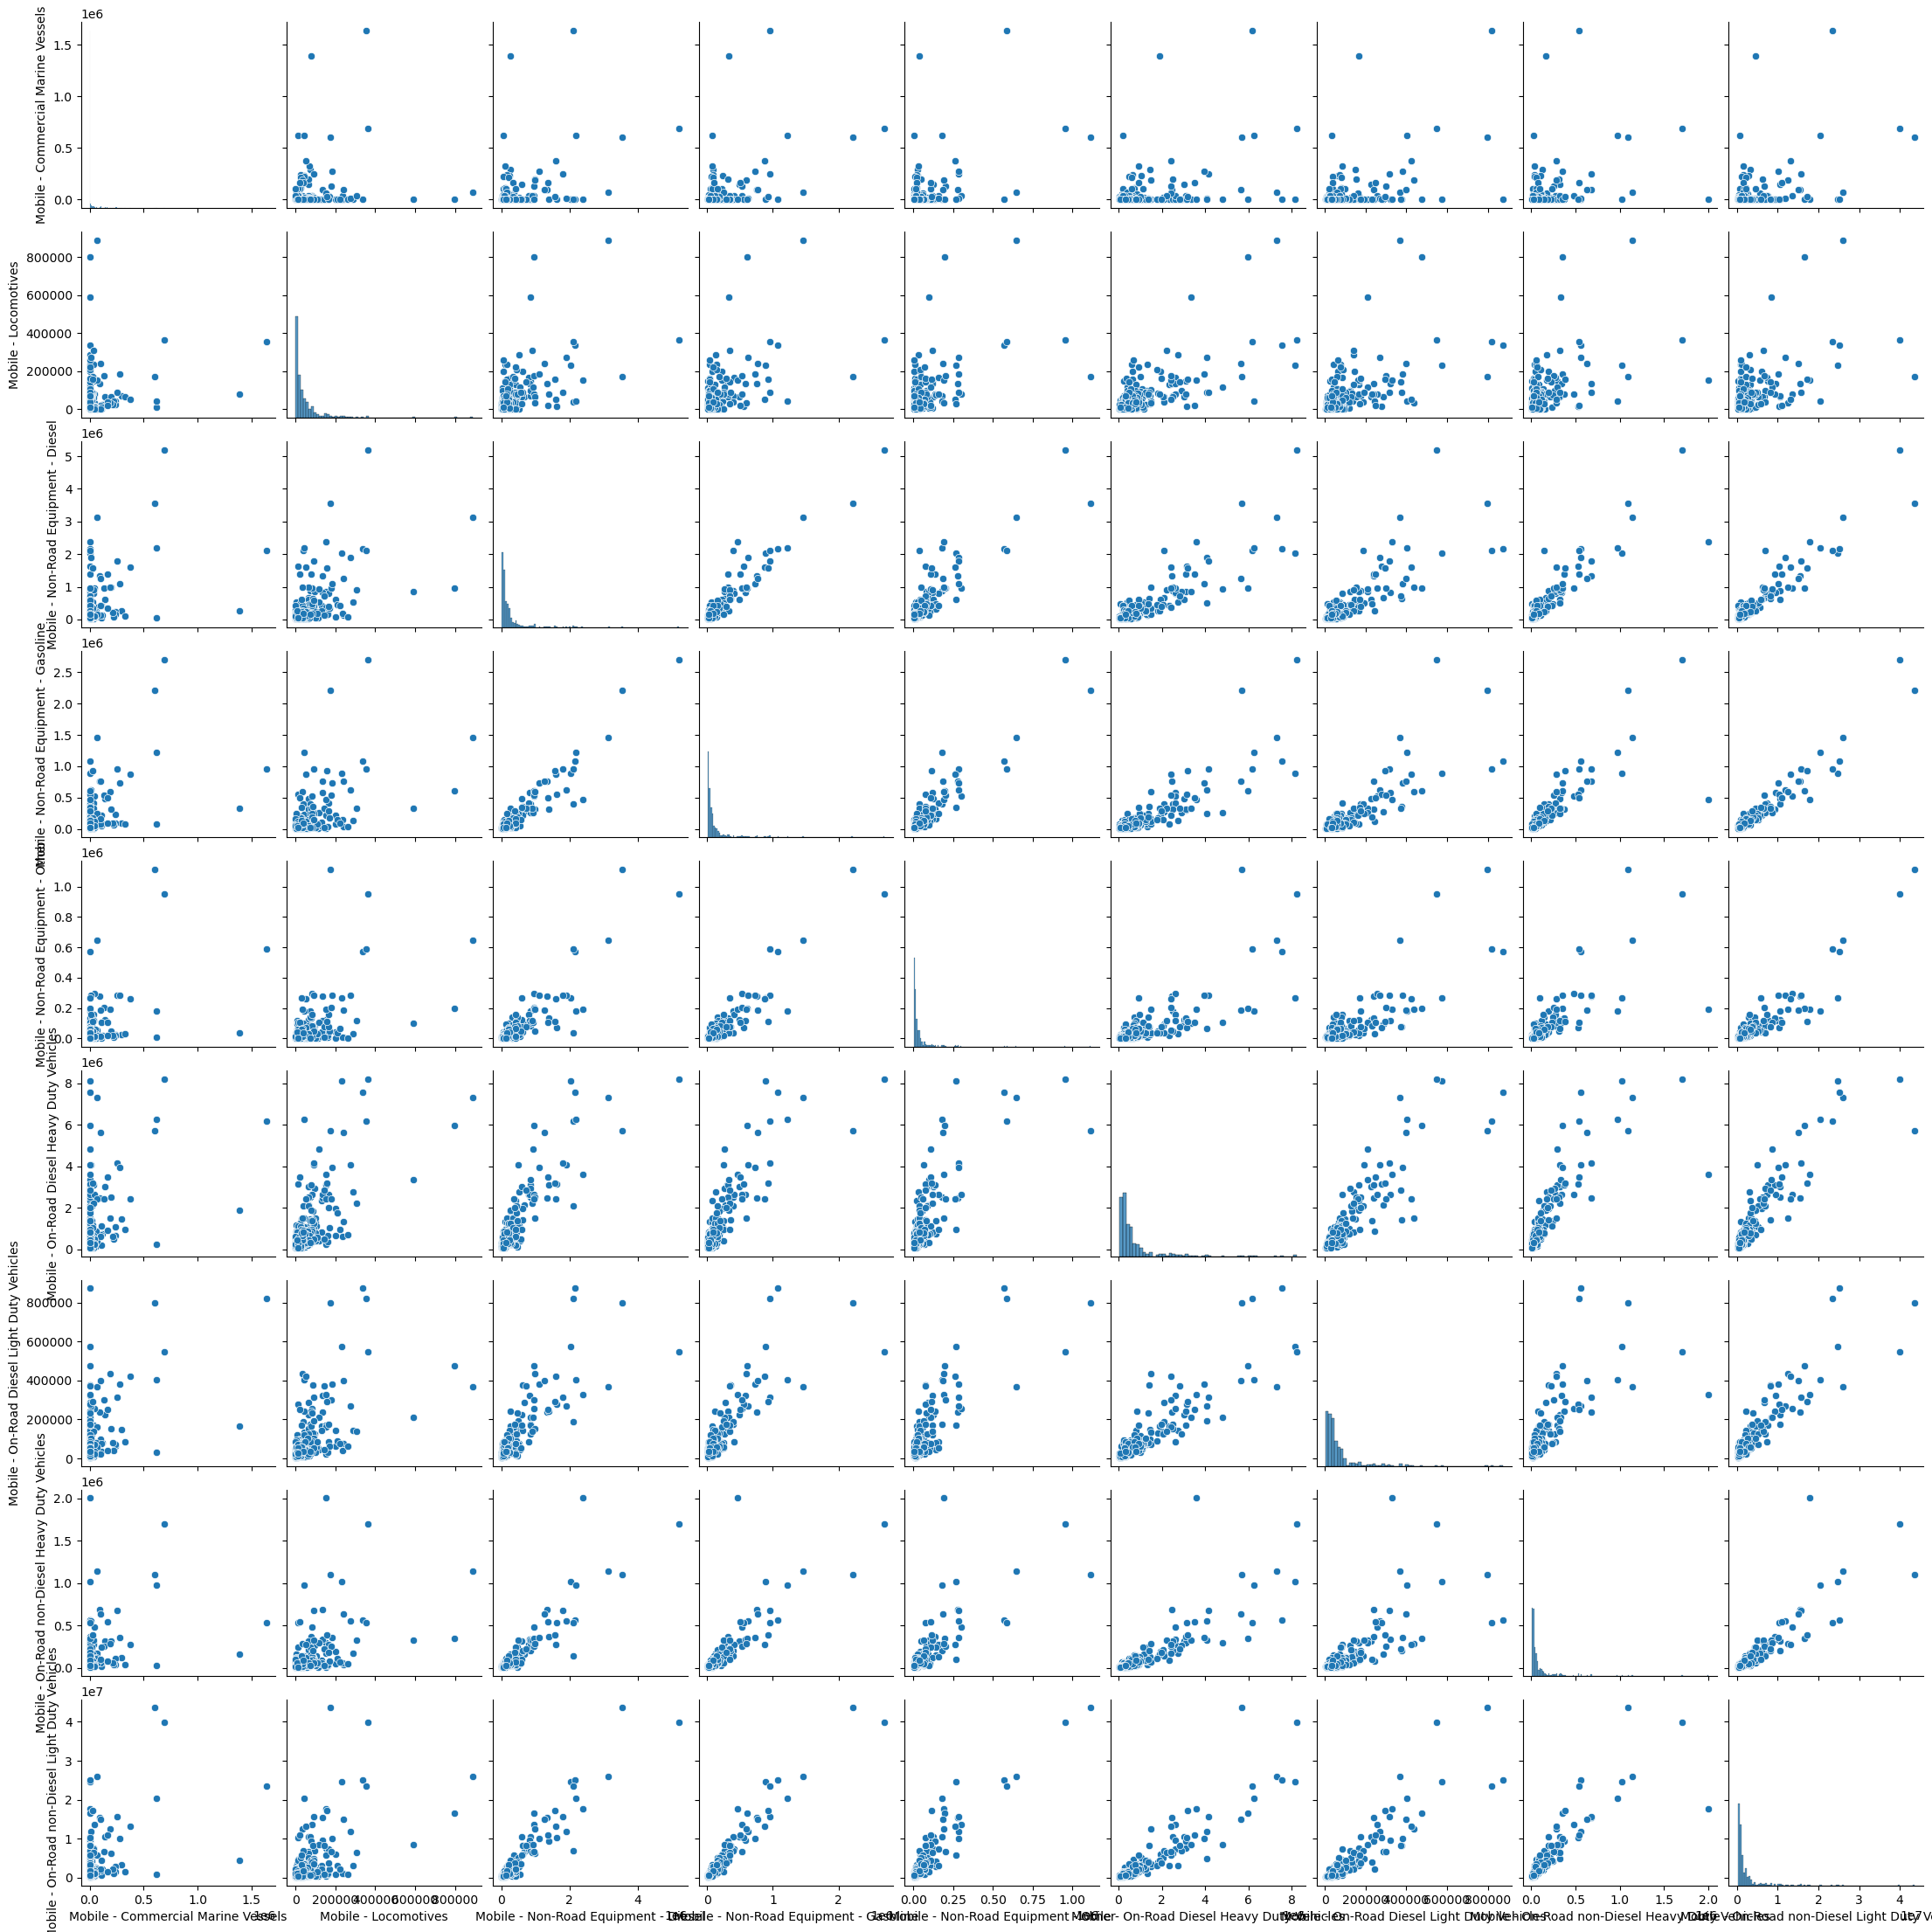

In [22]:
# Create pairplot
numeric_columns = [
    'Mobile - Commercial Marine Vessels',
    'Mobile - Locomotives',
    'Mobile - Non-Road Equipment - Diesel',
    'Mobile - Non-Road Equipment - Gasoline',
    'Mobile - Non-Road Equipment - Other',
    'Mobile - On-Road Diesel Heavy Duty Vehicles',
    'Mobile - On-Road Diesel Light Duty Vehicles',
    'Mobile - On-Road non-Diesel Heavy Duty Vehicles',
    'Mobile - On-Road non-Diesel Light Duty Vehicles'
]

sns.pairplot(sector_df[numeric_columns])
plt.show()

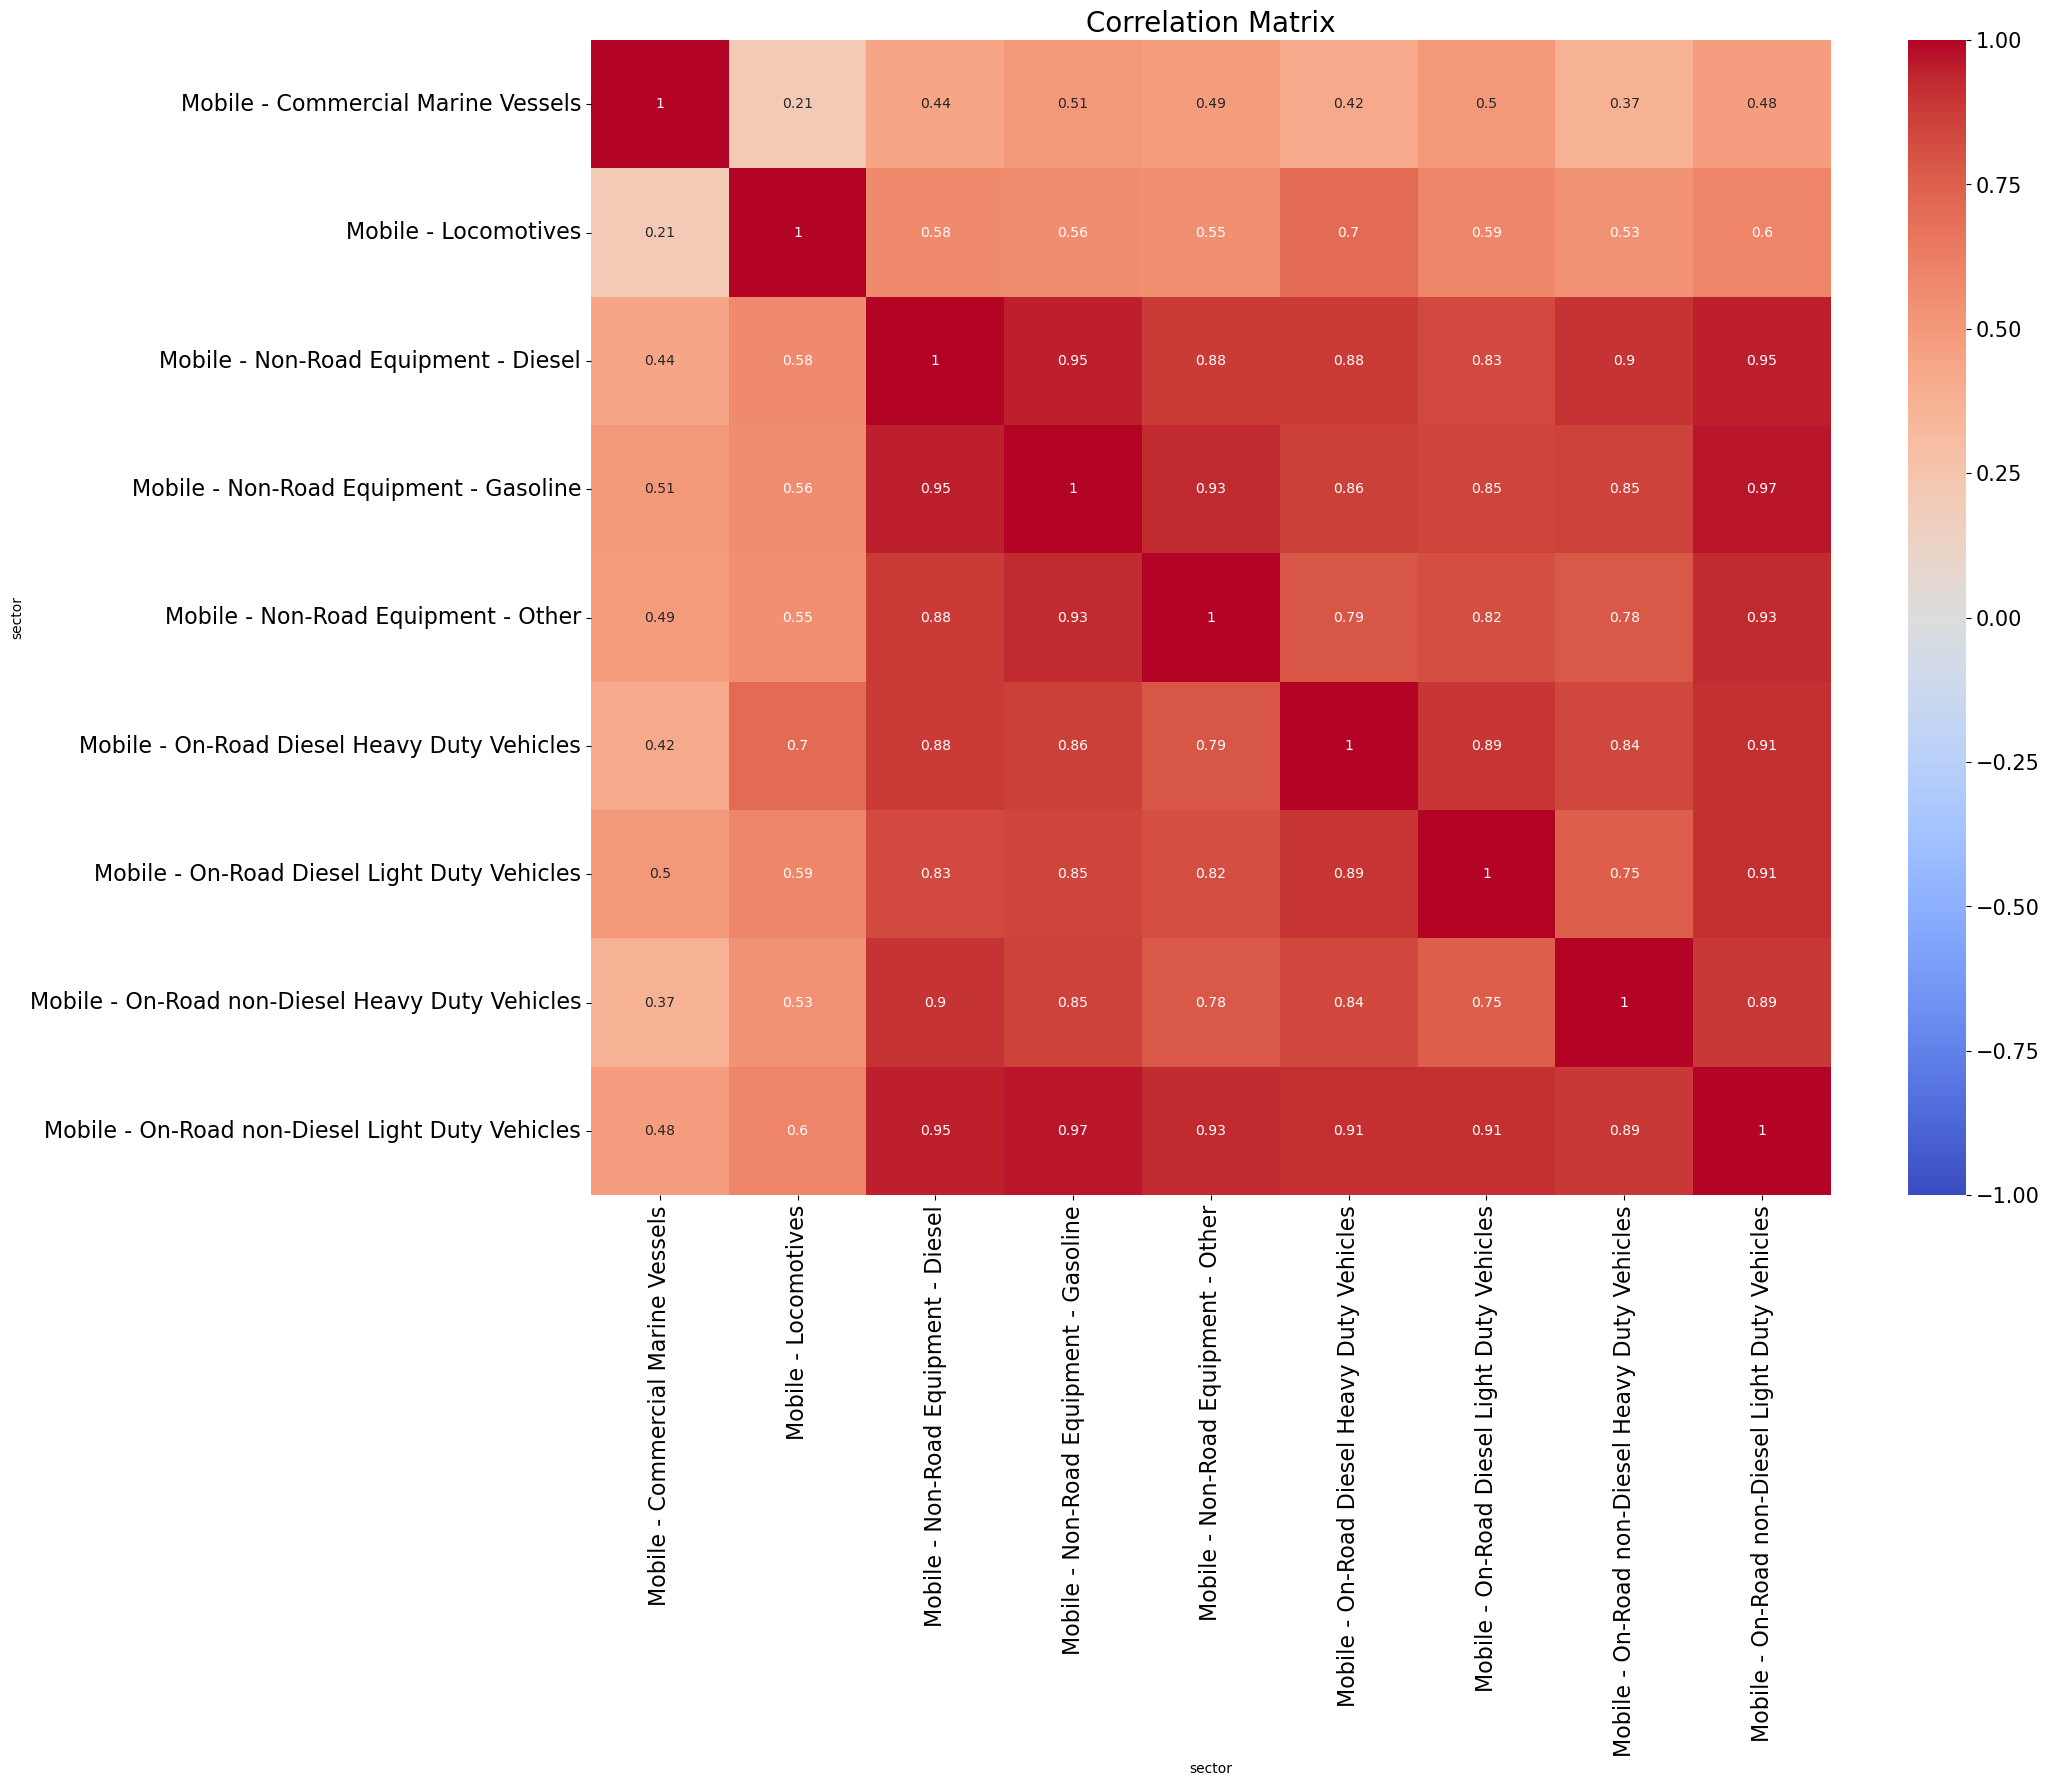

In [23]:
corr_matrix = sector_df[numeric_columns].corr()
corr_matrix 

# Assuming corr_matrix is already calculated
plt.figure(figsize=(20, 15))

# Plotting the correlation matrix with annotations
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Adjusting fontsize of x-axis and y-axis labels
plt.xticks(fontsize=15)  # X-axis labels size
plt.yticks(fontsize=15)  # Y-axis labels size

# Adjusting fontsize of annotations
plt.gcf().axes[0].tick_params(labelsize=16)  # Annotation fontsize

# Get the colorbar associated with the heatmap
cb = heatmap.collections[0].colorbar
cb.ax.tick_params(labelsize=15)  # Colorbar labels fontsize

plt.title('Correlation Matrix', fontsize=20)  # Title fontsize
plt.show()

In [24]:
# Extract the indicators for factor analysis
X = sector_df.drop('MSA', axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled 

array([[-0.22654878, -0.07704253, -0.20831873, ..., -0.25933449,
        -0.35774136, -0.3959915 ],
       [-0.22654878,  0.12671017, -0.11813188, ..., -0.4008499 ,
         0.04315133, -0.00605135],
       [-0.22654878, -0.49679769, -0.43122748, ..., -0.45711478,
        -0.33603109, -0.38509806],
       ...,
       [-0.22654878, -0.1280189 , -0.1942866 , ..., -0.33519532,
        -0.03510074, -0.14334256],
       [-0.22654878, -0.41811189, -0.42386733, ..., -0.41582938,
        -0.4415328 , -0.44321707],
       [-0.22654878,  0.26158127, -0.250561  , ..., -0.34893965,
        -0.32727828, -0.38550257]])

In [25]:

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    return estimator.bic(X)


param_grid = {
    "n_components": range(2, 8),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(random_state=222), param_grid=param_grid, scoring=gmm_bic_score
)

grid_search.fit(X_scaled) #Z_tsne

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score")#.head()

Number of components Type of covariance    BIC score
3                      5          spherical   128.555948
13                     3               diag   143.301467
2                      4          spherical   146.684330
1                      3          spherical   166.146068
4                      6          spherical   226.079143
14                     4               diag   238.067428
15                     5               diag   281.551530
5                      7          spherical   285.948410
16                     6               diag   450.401820
12                     2               diag   469.824509
0                      2          spherical   474.553938
18                     2               full   619.518014
17                     7               diag   695.963139
19                     3               full   938.594830
20                     4               full  1221.912526
21                     5               full  1258.088513
22                     6               full  1394.281276
7                      3               tied  1793.053850
6                      2               tied  1833.498684
23                     7               full  1877.934005
8                      4               tied  1922.927470
9                      5               tied  2067.253118
10                     6               tied  2099.707983
11                     7               tied  2268.133299

In [26]:
gmm = GaussianMixture(random_state=222, n_components=5,covariance_type="spherical")
gmm.fit(X_scaled)


GaussianMixture(covariance_type='spherical', n_components=5, random_state=222)

In [27]:
YY = gmm.predict(X_scaled)
color_iter = sns.color_palette("tab10", 5)[::1]
tcmap =   ListedColormap(color_iter)
types = ['Type 1', 'Type 2', 'Type 3','Type 4','Type 5']


In [28]:
sector_df['Cluster']=YY+1

In [29]:
sector_df

sector                                MSA  Mobile - Commercial Marine Vessels  \
0                             Abilene, TX                            0.000000   
1                               Akron, OH                            0.000000   
2                              Albany, GA                            0.000000   
3                      Albany-Lebanon, OR                            0.000000   
4             Albany-Schenectady-Troy, NY                         8360.938802   
..                                    ...                                 ...   
373                            Yakima, WA                            0.000000   
374                      York-Hanover, PA                            0.062451   
375     Youngstown-Warren-Boardman, OH-PA                            0.000000   
376                         Yuba City, CA                            0.000000   
377                              Yuma, AZ                            0.000000   

sector  Mobile - Locomotives  Mobile - Non-Road Equipment - Diesel  \
0               42460.589314                         168178.633388   
1               60394.788214                         213883.021594   
2                5513.973626                          55214.185076   
3               12140.569168                          66977.720338   
4               55662.033321                         239639.844504   
..                       ...                                   ...   
373             12423.580337                         194816.386289   
374              7726.991641                         251090.166120   
375             37973.677380                         175289.760097   
376             12439.853654                          58944.119531   
377             72266.067761                         146771.332390   

sector  Mobile - Non-Road Equipment - Gasoline  \
0                                 25162.152719   
1                                117819.833868   
2                                 19649.636201   
3                                 26031.719293   
4                                113680.565181   
..                                         ...   
373                               32651.446884   
374                               54128.805881   
375                               89115.494622   
376                               18879.235501   
377                               28665.800676   

sector  Mobile - Non-Road Equipment - Other  \
0                               5575.973966   
1                              45834.896393   
2                               5206.447020   
3                              14298.546775   
4                              51701.083275   
..                                      ...   
373                            12700.331615   
374                            40899.056847   
375                            37780.749641   
376                             4121.623079   
377                             3781.743835   

sector  Mobile - On-Road Diesel Heavy Duty Vehicles  \
0                                      6.922474e+05   
1                                      1.004440e+06   
2                                      2.716419e+05   
3                                      3.442422e+05   
4                                      1.081722e+06   
..                                              ...   
373                                    2.874612e+05   
374                                    4.550501e+05   
375                                    8.172946e+05   
376                                    7.368839e+04   
377                                    3.200484e+05   

sector  Mobile - On-Road Diesel Light Duty Vehicles  \
0                                      45067.596612   
1                                      29538.904551   
2                                      23364.876455   
3                                      42682.230602   
4                                      47838.851899   
..                           

In [30]:
# Replace 'your_shapefile_path' with the path to your shapefile
gdf = gpd.read_file('../../data/raw/cb_2018_us_cbsa_500k/cb_2018_us_cbsa_500k.shp')
us_state = gpd.read_file('../../data/raw/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
# Filter for Metropolitan Statistical Areas (MSA)
msa_gdf = gdf[(gdf['CBSAFP'].notnull()) & (gdf['LSAD'] == 'M1')]

# Extract city and state from NAME in df2
msa_gdf[['Area', 'State']] = msa_gdf['NAME'].str.split(', ', expand=True)
msa_gdf['Area'] = msa_gdf['Area'].str.split('-').str[0]
msa_gdf

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


CSAFP CBSAFP        AFFGEOID  GEOID  \
0    None  31340  310M400US31340  31340   
1     488  42220  310M400US42220  42220   
3     538  46140  310M400US46140  46140   
5    None  41740  310M400US41740  41740   
8     340  38220  310M400US38220  38220   
..    ...    ...             ...    ...   
934  None  42020  310M400US42020  42020   
936  None  49740  310M400US49740  49740   
938   222  20020  310M400US20020  20020   
939   408  14860  310M400US14860  14860   
941  None  48300  310M400US48300  48300   

                                              NAME LSAD        ALAND  \
0                                    Lynchburg, VA   M1   5491925729   
1                                   Santa Rosa, CA   M1   4081491107   
3                                        Tulsa, OK   M1  16238554204   
5                           San Diego-Carlsbad, CA   M1  10900649391   
8                                   Pine Bluff, AR   M1   5255934204   
..                                             ...  ...          ...   
934  San Luis Obispo-Paso Robles-Arroyo Grande, CA   M1   8548611925   
936                                       Yuma, AZ   M1  14281127830   
938                                     Dothan, AL   M1   4444678880   
939                Bridgeport-Stamford-Norwalk, CT   M1   1618651428   
941                                  Wenatchee, WA   M1  12277658519   

        AWATER                                           geometry  \
0     68559452  POLYGON ((-79.85840 37.26715, -79.85660 37.268...   
1    497455304  POLYGON ((-123.53354 38.76841, -123.52851 38.7...   
3    492994165  POLYGON ((-97.06448 36.68106, -97.06411 36.684...   
5    820695499  POLYGON ((-117.59615 33.38717, -117.59360 33.3...   
8    143446207  POLYGON ((-92.47391 34.00623, -92.47241 34.038...   
..         ...                                                ...   
934  815519172  POLYGON ((-121.34636 35.79518, -121.24378 35.7...   
936   13326079  POLYGON ((-114.81629 32.50804, -114.81432 32.5...   
938   33248036  POLYGON ((-86.19348 31.19221, -86.14167 31.192...   
939  549293518  MULTIPOLYGON (((-73.21717 41.14391, -73.21611 ...   
941  266186967  POLYGON ((-121.18080 47.89849, -121.17723 47.9...   

                Area State  
0          Lynchburg    VA  
1         Santa Rosa    CA  
3              Tulsa    OK  
5          San Diego    CA  
8         Pine Bluff    AR  
..               ...   ...  
934  San Luis Obispo    CA  
936             Yuma    AZ  
938           Dothan    AL  
939       Bridgeport    CT  
941        Wenatchee    WA  

[390 rows x 11 columns]

In [31]:

sector_df[['Area', 'State']] = sector_df['MSA'].str.split(', ', expand=True)
sector_df['Area'] = sector_df['Area'].str.split('-').str[0]

if isinstance(sector_df.columns, pd.MultiIndex):
    sector_df.columns = sector_df.columns.get_level_values(0)
if isinstance(msa_gdf.columns, pd.MultiIndex):
    msa_gdf.columns = msa_gdf.columns.get_level_values(0)

# Merge the dataframes on the 'Area' and 'State' columns
merged_df_1 = msa_gdf.merge(sector_df, on=['Area', 'State'], suffixes=('_pivot', '_msa'))
merged_df_1

CSAFP CBSAFP        AFFGEOID  GEOID  \
0    None  31340  310M400US31340  31340   
1     488  42220  310M400US42220  42220   
2     538  46140  310M400US46140  46140   
3    None  41740  310M400US41740  41740   
4     340  38220  310M400US38220  38220   
..    ...    ...             ...    ...   
370  None  42020  310M400US42020  42020   
371  None  49740  310M400US49740  49740   
372   222  20020  310M400US20020  20020   
373   408  14860  310M400US14860  14860   
374  None  48300  310M400US48300  48300   

                                              NAME LSAD        ALAND  \
0                                    Lynchburg, VA   M1   5491925729   
1                                   Santa Rosa, CA   M1   4081491107   
2                                        Tulsa, OK   M1  16238554204   
3                           San Diego-Carlsbad, CA   M1  10900649391   
4                                   Pine Bluff, AR   M1   5255934204   
..                                             ...  ...          ...   
370  San Luis Obispo-Paso Robles-Arroyo Grande, CA   M1   8548611925   
371                                       Yuma, AZ   M1  14281127830   
372                                     Dothan, AL   M1   4444678880   
373                Bridgeport-Stamford-Norwalk, CT   M1   1618651428   
374                                  Wenatchee, WA   M1  12277658519   

        AWATER                                           geometry  \
0     68559452  POLYGON ((-79.85840 37.26715, -79.85660 37.268...   
1    497455304  POLYGON ((-123.53354 38.76841, -123.52851 38.7...   
2    492994165  POLYGON ((-97.06448 36.68106, -97.06411 36.684...   
3    820695499  POLYGON ((-117.59615 33.38717, -117.59360 33.3...   
4    143446207  POLYGON ((-92.47391 34.00623, -92.47241 34.038...   
..         ...                                                ...   
370  815519172  POLYGON ((-121.34636 35.79518, -121.24378 35.7...   
371   13326079  POLYGON ((-114.81629 32.50804, -114.81432 32.5...   
372   33248036  POLYGON ((-86.19348 31.19221, -86.14167 31.192...   
373  549293518  MULTIPOLYGON (((-73.21717 41.14391, -73.21611 ...   
374  266186967  POLYGON ((-121.18080 47.89849, -121.17723 47.9...   

                Area  ... Mobile - Commercial Marine Vessels  \
0          Lynchburg  ...                           0.000000   
1         Santa Rosa  ...                        1222.371474   
2              Tulsa  ...                        1206.562560   
3          San Diego  ...                      190812.601013   
4         Pine Bluff  ...                        9714.151500   
..               ...  ...                                ...   
370  San Luis Obispo  ...                         610.009888   
371             Yuma  ...                           0.000000   
372           Dothan  ...                           0.056972   
373       Bridgeport  ...                       15655.495169   
374        Wenatchee  ...                           0.000000   

    Mobile - Locomotives  Mobile - Non-Road Equipment - Diesel  \
0           58310.208201                          66161.004167   
1            1437.798178                         133717.696800   
2          163048.167598                         388033.056503   
3           32450.442671                         982534.305180   
4           60614.185568                          83680.585337   
..                   ...                                   ...   
370          2321.663108                         117283.817820   
371         72266.067761                         146771.332390   
372          4235.424227                          59167.483834   
373         19072.570356                         266536.265541   
374         25036.470583                          76204.199887   

     Mobile - Non-Road Equipment - Gasoline  \
0                              29494.339370   
1                              98628.315522   
2                             291068.719860   
3                             593753.860003

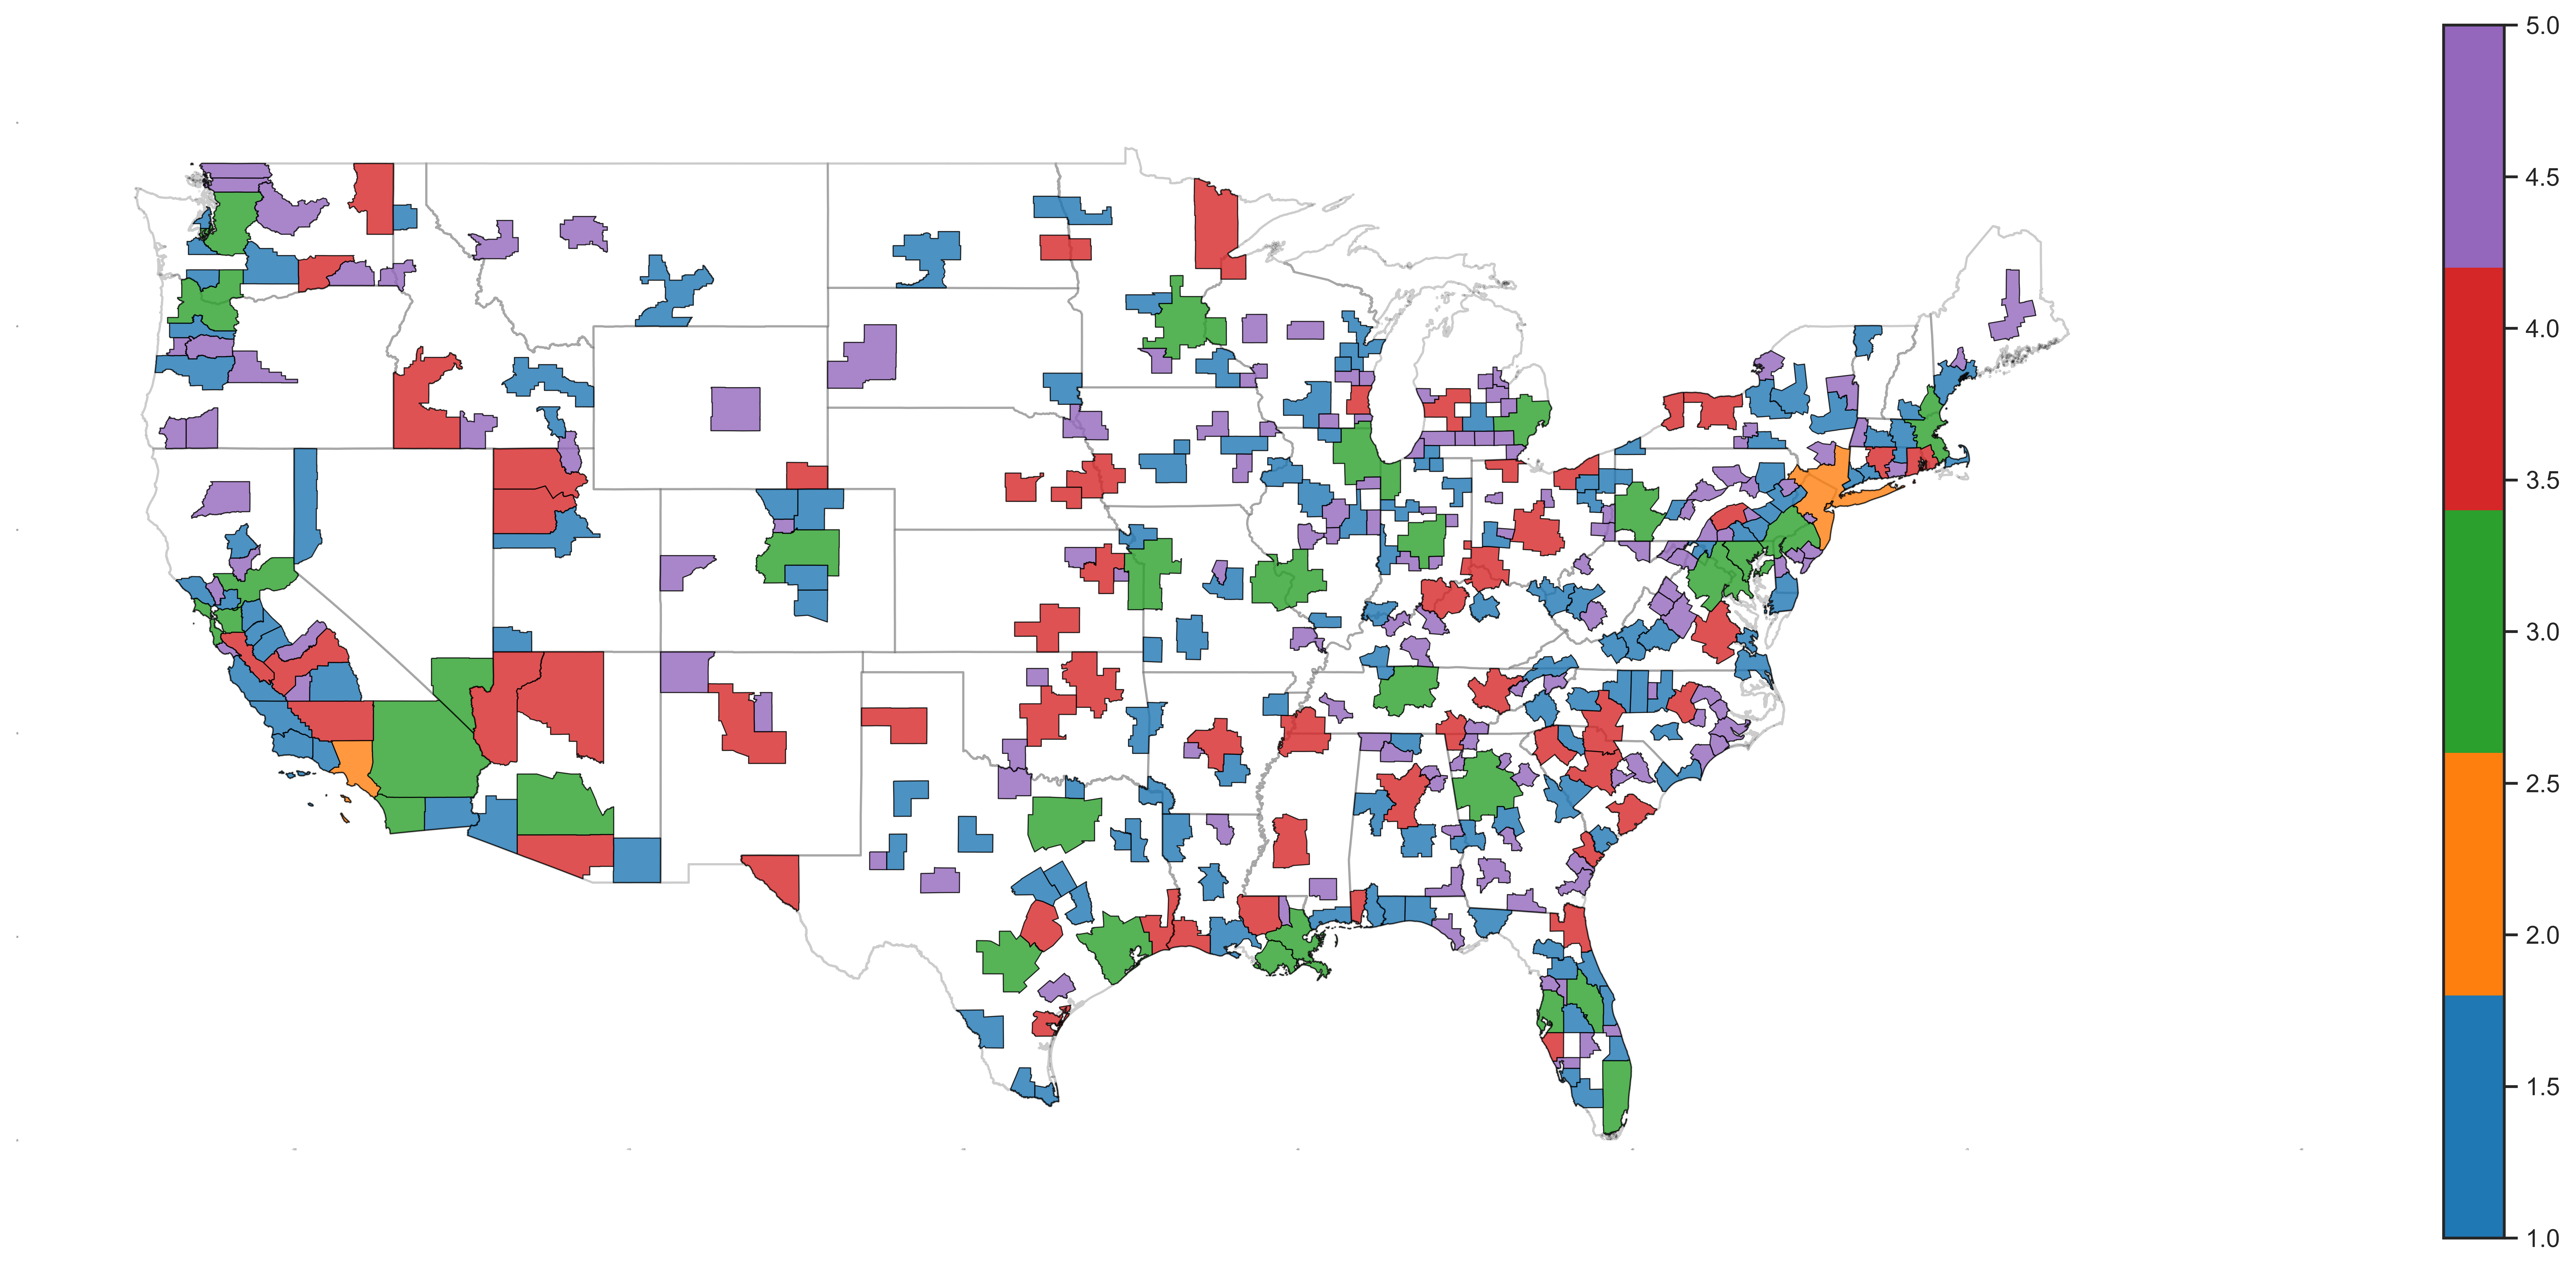

In [32]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(18, 8), dpi=600)

# usa = gpd.read_file('us_shapefile.shp')
# usa = gpd.read_file('us_shapefile_simple.shp')
# usa = gpd.read_file('us_shapefile_complex.shp')
#usa = gpd.read_file('us_shapefile_less.shp')
color_iter_cmap = ListedColormap(sns.color_palette("tab10", 5)[::1])

# Plot using geopandas
us_state.plot(ax=ax, alpha=0.2, facecolor='white', edgecolor='black')
merged_df_1.plot(ax=ax, alpha=0.8, column='Cluster',cmap=color_iter_cmap, legend=True, edgecolor='black',linewidth=.5)

# sns.scatterplot(x="lon", y="lat",  hue="Type", size="Street density (km/sq km)", sizes=(20, 150), 
#                 data=cbsa_shp, alpha=.8,
#                 ax=ax,
#                 palette=color_iter,
#                 )

plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.xlim(-128, -60)
plt.ylim(25, 50)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='both', labelsize=0)
#ax.set_label(fontsize=20)
#plt.legend(loc="right",frameon=False,bbox_to_anchor=(1.05,.3), fontsize=16)#.set_visible(True)
plt.tight_layout()
plt.savefig('../../figures/typemap-emissions.png',dpi=360)